# BA890 Research Project
## Bitcoin Price Prediction
##### Name: Tzu-Hua Huang

# 1. Introduction
Recently, the meteoric increase in the value of Bitcoin makes cryptocurrency prediction become a more popular topic among investors worldwide. The first Bitcoin protocol and proof of concept were published in 2009 by a shadowy individual or group under the pseudonym Satoshi Nakamoto. Bitcoin inventor(s) aimed at creating a distributed network system, where people could manage their funds more transparently. After Nakamoto left the project in late 2010, other developers took over and the Bitcoin community has kept growing over the past decade. 

Bitcoin has certainly produced no shortage of controversy. However, considering the volatility of the crypto market and Bitcoin prices, the transactions of Bitcoin are still worth research. In this project, I would like to study Bitcoin price forecasting and time series modeling.

## 1.1 Data Source
The "Bitcoin Historical Data" dataset, which is downloaded from [Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data). The dataset includes historical bitcoin market data at 1-min intervals for select bitcoin exchanges from Jan 2012 to March 2021. There are eight columns, includes one column of timestamp, and the updates of `Open`, `High`, `Low`, `Close`, `Volume in BTC`, `Volume of corresponding currency`, and `Weighted Price`.

## 1.2 Variables
* Open: the opening price of the time period
* High: the highest price of the time period
* Low: the lowest price of the time period
* Close: the closing price of the time period
* Volume in BTC: the volume in the transacted currency, i.e. For BTC/USDT, this is in BTC amount
* Volume of corresponding currency: the volume in the base/converted currency, i.e. For BTC/USDT, this is in USDT amount
* Weighted Price: the price weighted by trading volume

## 1.3 Methods
* Double Exponential Smoothing Estimations
* ARIMA (Auto-Regressive Integrated Moving Average) Model
* XGBoost
* LSTM (Long short-term memory) Networks

# 2. Data Preparation

## 2.1 Set-up and Data Set Overview

In [ ]:
!pip install pmdarima

In [ ]:
!pip3 install keras

In [ ]:
!pip3 install tensorflow

In [ ]:
!pip3 install xgboost

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

import datetime as dt

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from math import sqrt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
# load data set
df = pd.read_csv('Bitcoin Historical Data.csv')

# check data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN

## 2.2 Data Pre-processing

In [ ]:
# convert Timestamp's datatype from int to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit = 's')

# check data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 296.5 MB


Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00   NaN   NaN   NaN    NaN           NaN   
2 2011-12-31 07:54:00   NaN   NaN   NaN    NaN           NaN   
3 2011-12-31 07:55:00   NaN   NaN   NaN    NaN           NaN   
4 2011-12-31 07:56:00   NaN   NaN   NaN    NaN           NaN   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                NaN             NaN  
2                NaN             NaN  
3                NaN             NaN  
4                NaN             NaN

In [ ]:
# check null values
df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

- Fill the data of indices during which there were no trades occuring, single-event. We can ignore the trades and set value=0.
- Modify features `open`, `high`, `low`, `close`. Since we are dealing with time series data, which is continuous, we use forward filling, `ffill`.

In [ ]:
# handle missing values
# treat columns without trades as single events
# fill the NaNs with zeroes
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# deal with the OHLC (open/high/low/close) columns using forwards filling
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

# rename columns
df.rename(columns={"Volume_(BTC)" : "Volume_BTC", "Volume_(Currency)" : "Volume_Currency"}, inplace=True)

df.head()

Timestamp  Open  High   Low  Close  Volume_BTC  Volume_Currency  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39    0.455581              2.0   
1 2011-12-31 07:53:00  4.39  4.39  4.39   4.39    0.000000              0.0   
2 2011-12-31 07:54:00  4.39  4.39  4.39   4.39    0.000000              0.0   
3 2011-12-31 07:55:00  4.39  4.39  4.39   4.39    0.000000              0.0   
4 2011-12-31 07:56:00  4.39  4.39  4.39   4.39    0.000000              0.0   

   Weighted_Price  
0            4.39  
1            0.00  
2            0.00  
3            0.00  
4            0.00

In [ ]:
# convert minutely data to daily basis
df_daily = df.copy()

# reset index
df_daily.set_index('Timestamp', inplace=True)

# retrieve columns's average on daily basis
df_daily = df_daily.resample('D').mean()

# drop missing values
df_daily = df_daily.dropna()
df_daily

Open          High           Low         Close  \
Timestamp                                                            
2011-12-31      4.472552      4.472624      4.472552      4.472624   
2012-01-01      4.680778      4.680778      4.680778      4.680778   
2012-01-02      5.000000      5.000000      5.000000      5.000000   
2012-01-03      5.145917      5.145917      5.145917      5.145917   
2012-01-04      5.176708      5.228729      5.176708      5.228729   
...                  ...           ...           ...           ...   
2021-03-27  55192.193146  55218.558944  55167.838403  55194.452319   
2021-03-28  55834.184958  55858.268208  55811.112208  55835.612028   
2021-03-29  56911.283486  56942.541743  56881.677681  56911.995660   
2021-03-30  58346.922167  58371.047285  58323.091465  58348.516944   
2021-03-31  58767.750000  58778.180000  58755.970000  58778.180000   

            Volume_BTC  Volume_Currency  Weighted_Price  
Timestamp                                                
2011-12-31    0.098469         0.439381        0.018478  
2012-01-01    0.015001         0.073458        0.010014  
2012-01-02    0.013228         0.066139        0.003472  
2012-01-03    0.061137         0.322781        0.029181  
2012-01-04    0.074468         0.394497        0.032551  
...                ...              ...             ...  
2021-03-27    1.812477    100254.202790    54848.398777  
2021-03-28    1.439895     80184.159067    55522.775719  
2021-03-29    3.722518    213160.793333    56755.899392  
2021-03-30    2.355791    137751.272336    58144.318823  
2021-03-31    2.712831    159417.751000    58764.349363  

[3376 rows x 7 columns]

In [ ]:
# print shape
print(df_daily.shape)

(3376, 7)


# 3. Exploratory Data Analysis

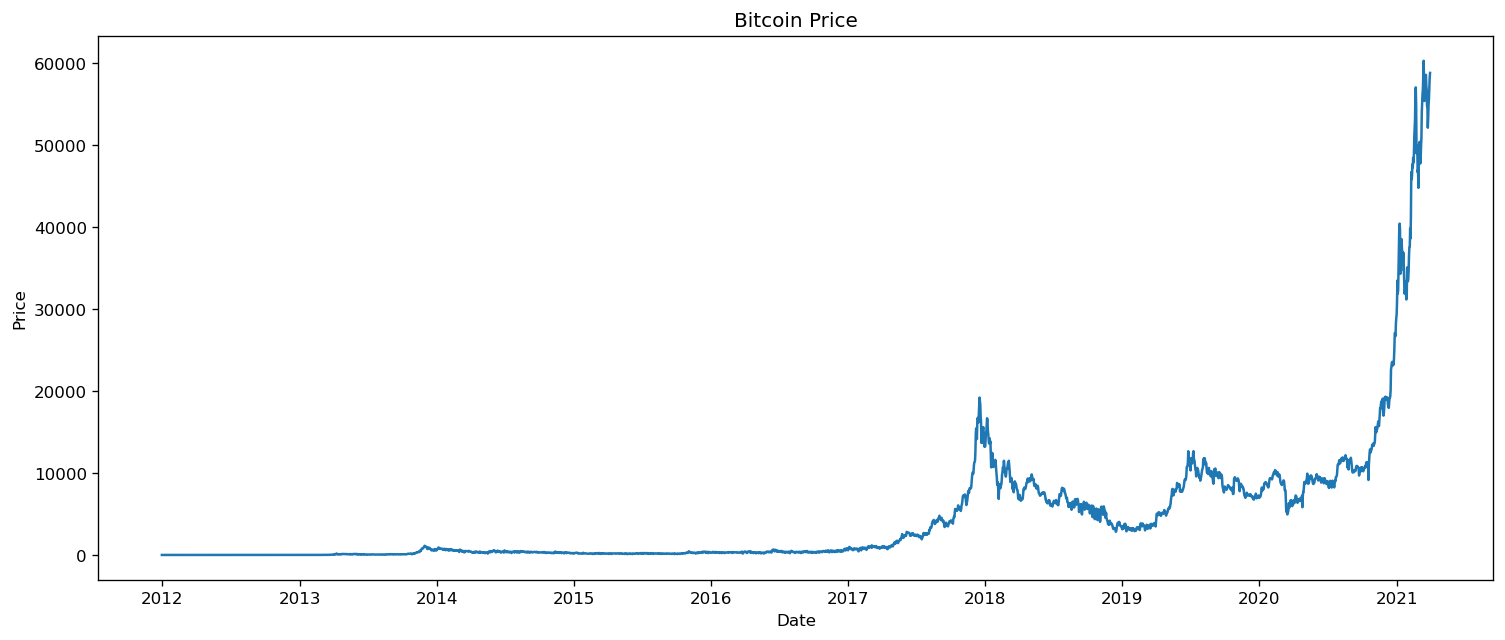

In [ ]:
# plot data
plt.figure(figsize=(15,6))
plt.plot(df_daily['Weighted_Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

- As shown in the graph, we can see that the price between 2012 and 2017 looks signficantly different from the price between 2017 and 2021.
- The price has been fluctuated after 2017. We can find upward and downward trends in different periods.

Next, group the data at seasonal intervals and see the distribution of monthly/yearly values to have an overview of price changes.

In [ ]:
# prepare data for plotting
df['Date'] = pd.to_datetime(df['Timestamp']).dt.date
temp = df.copy()
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Year'] = temp['Date'].dt.year
temp['Month'] = temp['Date'].dt.month

# repeat steps for creating daily dataframe
temp.set_index('Date', inplace=True)
temp = temp.resample('D').mean()
temp = temp.dropna()
temp.head()

Open      High       Low     Close  Volume_BTC  \
Date                                                             
2011-12-31  4.472552  4.472624  4.472552  4.472624    0.098469   
2012-01-01  4.680778  4.680778  4.680778  4.680778    0.015001   
2012-01-02  5.000000  5.000000  5.000000  5.000000    0.013228   
2012-01-03  5.145917  5.145917  5.145917  5.145917    0.061137   
2012-01-04  5.176708  5.228729  5.176708  5.228729    0.074468   

            Volume_Currency  Weighted_Price    Year  Month  
Date                                                        
2011-12-31         0.439381        0.018478  2011.0   12.0  
2012-01-01         0.073458        0.010014  2012.0    1.0  
2012-01-02         0.066139        0.003472  2012.0    1.0  
2012-01-03         0.322781        0.029181  2012.0    1.0  
2012-01-04         0.394497        0.032551  2012.0    1.0

In [ ]:
# convert data type
temp['Year'] = temp['Year'].astype('int64')
temp['Month'] = temp['Month'].astype('int64')

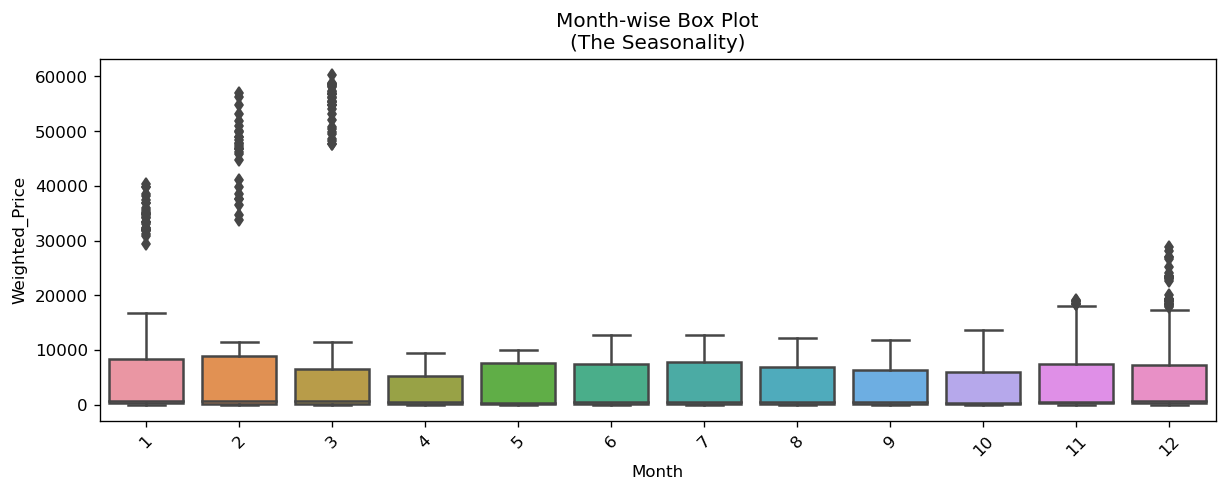

In [ ]:
# boxplot of month-wise (Seasonal) distribution
sns.boxplot(x='Month', y='Weighted_Price', data=temp)
plt.title('Month-wise Box Plot\n(The Seasonality)')
plt.xticks(rotation = '45')
plt.show()

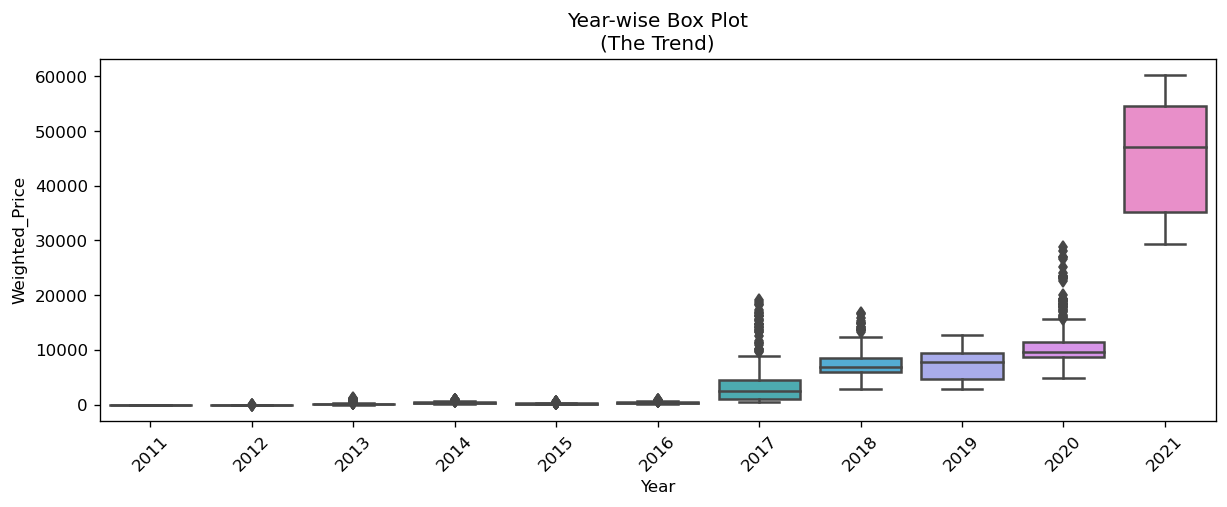

In [ ]:
# boxplot of year-wise (trend) distribution
sns.boxplot(x='Year', y='Weighted_Price', data=temp)
plt.title('Year-wise Box Plot\n(The Trend)')
plt.xticks(rotation = '45')
plt.show()

### Findings
The boxplots above present the year-wise and month-wise distributions. According to the month-wise boxplot, we can't find significant seasonality. On the other hand, the year-wise boxplot indicates a trend and fluctuation in the past decade. We will have further inspections as below.

# 4. Time Series Forecasting Preparation

## 4.1 Test for Stationarity
We use Augmented Dickey Fuller test (ADF Test) to test for stationarity, where the null hypothesis is the time series possesses a unit root and is non-stationary.

In [ ]:
# DF unit test
# p-value > 0.05 => not rejecting H0 => non-stationary => need to account for trend
from statsmodels.tsa.stattools import adfuller

ad_result = adfuller(df_daily['Weighted_Price'])
print('ADF Statistic: %f' % ad_result[0])
print('p-value: %f' % ad_result[1])

ADF Statistic: 6.133335
p-value: 1.000000


Since p-value is greater than the significance level (0.05), we fail to reject the null hypothesis. The time series is non-stationary.

## 4.2 Test for Seasonality
To test for seasonality, we plot the series and check if there is any repeatable pattern in fixed time intervals. 

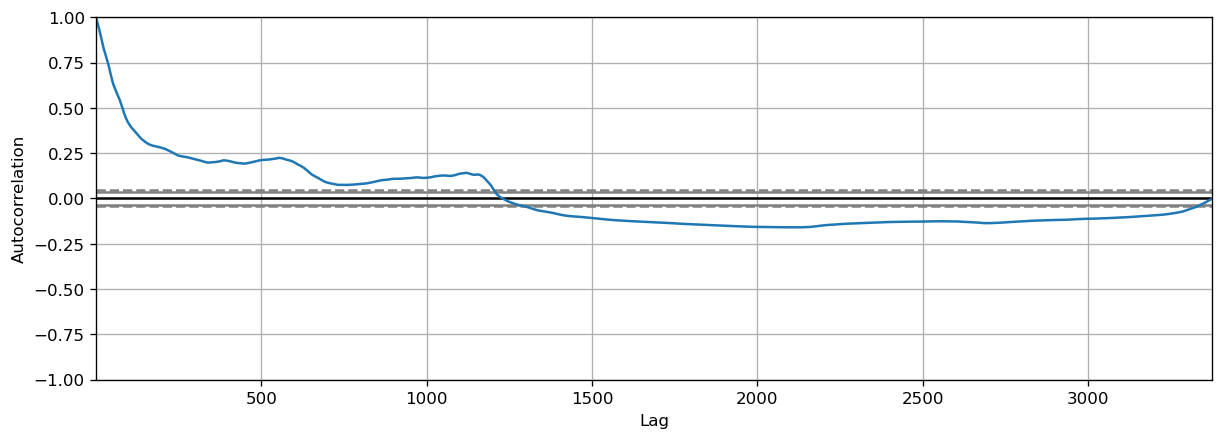

In [ ]:
from pandas.plotting import autocorrelation_plot

# plot
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})
autocorrelation_plot(df_daily['Weighted_Price'].tolist())

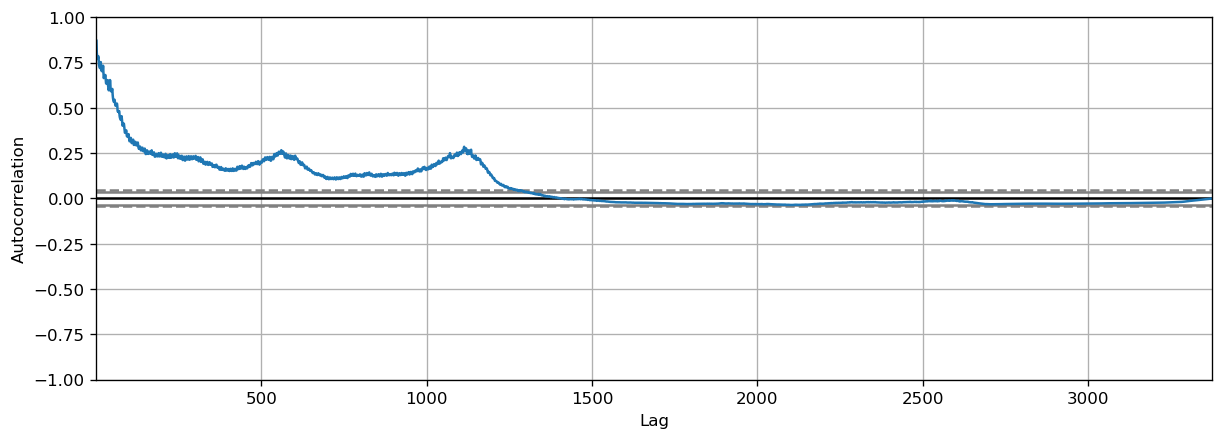

In [ ]:
# plot the autocorrelation to see if there are lags in the time series
autocorrelation_plot(df_daily)
plt.show()

According to the above plots, there are two spikes at approximately 550th and 1100th, but after the two points, there are no more regular spikes can be found.

Since Bitcoin price in the first couple years didn't properly represent the price movement, in order to improve the accuracy of the prediction, we will focus on the later data presenting volatility, i.e. the data from Arpil 1st, 2017 to March 31st, 2021.

In [ ]:
# extract and save as a four-year dataframe
df2 = pd.DataFrame()
df2 = df_daily.loc['2017-04-01':, :]
df2

Open          High           Low         Close  \
Timestamp                                                            
2017-04-01   1077.393160   1077.893264   1077.001285   1077.520590   
2017-04-02   1079.834194   1080.529444   1079.333104   1079.922000   
2017-04-03   1126.428604   1127.157611   1125.832104   1126.591181   
2017-04-04   1142.354611   1142.863743   1141.868458   1142.401174   
2017-04-05   1130.077007   1130.468722   1129.713660   1130.145181   
...                  ...           ...           ...           ...   
2021-03-27  55192.193146  55218.558944  55167.838403  55194.452319   
2021-03-28  55834.184958  55858.268208  55811.112208  55835.612028   
2021-03-29  56911.283486  56942.541743  56881.677681  56911.995660   
2021-03-30  58346.922167  58371.047285  58323.091465  58348.516944   
2021-03-31  58767.750000  58778.180000  58755.970000  58778.180000   

            Volume_BTC  Volume_Currency  Weighted_Price  
Timestamp                                                
2017-04-01    3.617450      3900.913732      909.182172  
2017-04-02    5.305483      5746.311335      883.985656  
2017-04-03    7.692266      8671.970576     1071.202072  
2017-04-04    5.153379      5883.224100     1046.232638  
2017-04-05    3.881234      4374.737116      971.200287  
...                ...              ...             ...  
2021-03-27    1.812477    100254.202790    54848.398777  
2021-03-28    1.439895     80184.159067    55522.775719  
2021-03-29    3.722518    213160.793333    56755.899392  
2021-03-30    2.355791    137751.272336    58144.318823  
2021-03-31    2.712831    159417.751000    58764.349363  

[1461 rows x 7 columns]

In [ ]:
# check descriptive statistics
df2.describe()

Open          High           Low         Close   Volume_BTC  \
count   1461.000000   1461.000000   1461.000000   1461.000000  1461.000000   
mean   10189.465734  10196.733176  10181.865012  10189.453974     6.981486   
std    10029.644386  10038.009416  10021.101859  10029.856063     5.039359   
min     1077.393160   1077.893264   1077.001285   1077.520590     0.582846   
25%     5485.037271   5486.227611   5483.983167   5485.194153     3.604738   
50%     8018.286139   8022.671396   8015.542257   8018.323653     5.735985   
75%    10344.727882  10351.424097  10338.138965  10343.264611     8.802172   
max    60459.913292  60490.422764  60428.069590  60460.518250    49.278729   

       Volume_Currency  Weighted_Price  
count      1461.000000     1461.000000  
mean      68178.044596    10029.240412  
std       81787.591498    10073.009740  
min        1477.824875      706.020061  
25%       22565.390767     5132.261169  
50%       41166.050779     7948.835364  
75%       80604.691508    10209.393250  
max      950995.602917    60245.928704

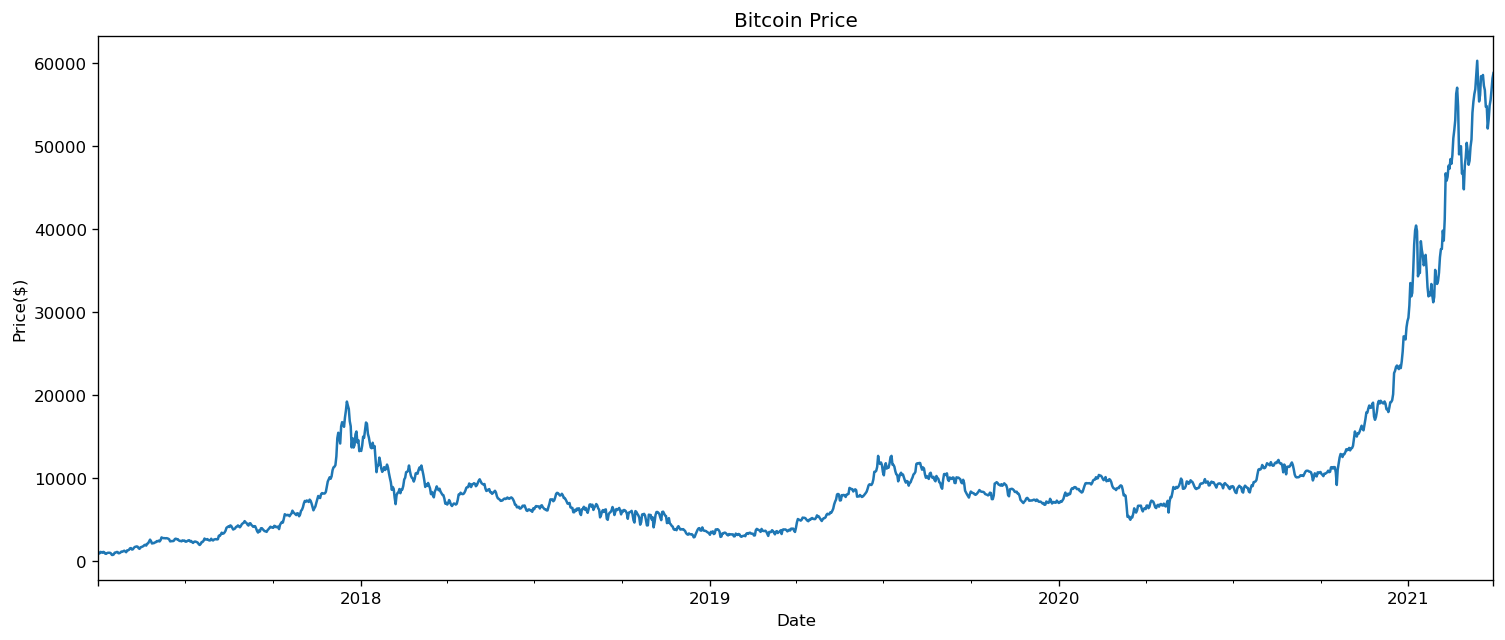

In [ ]:
# again, plot the data
df2['Weighted_Price'].plot(title = "Bitcoin Price", figsize=(15,6))
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.show()

# 5. Time Series Forecasting

## 5.1 Model 1. Double Exponential Smoothing (DES) Estimations
Since trend is detected in the time series, we have to account for trend when we predict. First, we will apply double exponential smoothing (DES) estimations.

In [ ]:
df2.shape

(1461, 7)

We will have some settings as follows:
- Use the first 70% data, i.e. 1022 days as training sample
- Try alpha and beta from 0 to 1 with 0.05 increments
- Assume a burn-in period of 50 days
- Calculate training sample MSE and RSME for days 51 to 1022
- Forecast for the rest of 30% data, i.e. the last 439 days
- `DES*` indicates **Optimal DES(alpha,beta) with optimal combination of alpha and beta**

In [ ]:
# training sample: first 1022 days (forecast for the last 439 days)
# allow 50 days of burn-in period
# DES for days 51 to 1022 (index 50-1021)
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# define a function generating the training sample MSE
def DESMSE(alpha, beta):
    return mean_squared_error(df2.Weighted_Price[50:1022], 
                              ExponentialSmoothing(df2.Weighted_Price[:1022], trend='add', initialization_method='estimated').fit(smoothing_level = alpha, smoothing_trend = beta).predict(50, 1021))

In [ ]:
# define grid search function for searching optimal combination of alpha and beta
from itertools import product
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())],
                        columns=dictionary.keys())

In [ ]:
# try alpha and beta from 0 to 1 with 0.05 increments
# define the alpha and beta values to try as a dictionary
dictionary = {'Alpha': np.arange(0.0, 1.0, 0.05), 
              'Beta': np.arange(0.0, 1.0, 0.05)}

# construct alpha,beta values to try 
des_results = expand_grid(dictionary)

# add a column called MSE to save the MSE results later
des_results['MSE'] = np.repeat(0, len(des_results))
des_results[:5]

Alpha  Beta  MSE
0    0.0  0.00    0
1    0.0  0.05    0
2    0.0  0.10    0
3    0.0  0.15    0
4    0.0  0.20    0

In [ ]:
# temporarily suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# reuse the DESMSE function to loop through all alpha beta values
for alpha in np.arange(0.0, 1.01, 0.05):
    for beta in np.arange(0.0, 1.01, 0.05):
        des_results.loc[(des_results['Alpha'] == alpha) & (des_results['Beta'] == beta),'MSE'] = DESMSE(alpha, beta)

# find the best alpha beta combination
des_results.sort_values('MSE').head(5)

Alpha  Beta            MSE
380   0.95  0.00  141097.439602
360   0.90  0.00  143882.598287
381   0.95  0.05  143887.316178
361   0.90  0.05  146486.510172
382   0.95  0.10  146817.815616

When alpha = 0.95, beta = 0.00, DES has the optimal combination of alpha and beta.

In [ ]:
# DES(0.95, 0.00) gives the lowest MSE
# alpha = 0.95, beta = 0.00
# calculate training sample MSE for the first 70% data (days 51 to 1022)
DESMSE(0.95, 0.00)

141097.4397613641

In [ ]:
# forecast for the last 30% data (439 days)
# store DES(0.95, 0.00) in the holdout sample
df2.loc[df2.index[1022:], 'DES'] = ExponentialSmoothing(df2.Weighted_Price[:1022], trend='add',
                                                        initialization_method='estimated').fit(smoothing_level = 0.95, smoothing_trend = 0.00).forecast(439)

# print test MSE
mse_des = mean_squared_error(df2.Weighted_Price[1022:], df2.DES[1022:])
print('Test MSE:', round(mse_des, 2))

# print test RMSE
rmse_des = sqrt(mse_des)
print('Test RMSE:', round(rmse_des, 2))

Test MSE: 253990582.23
Test RMSE: 15937.08


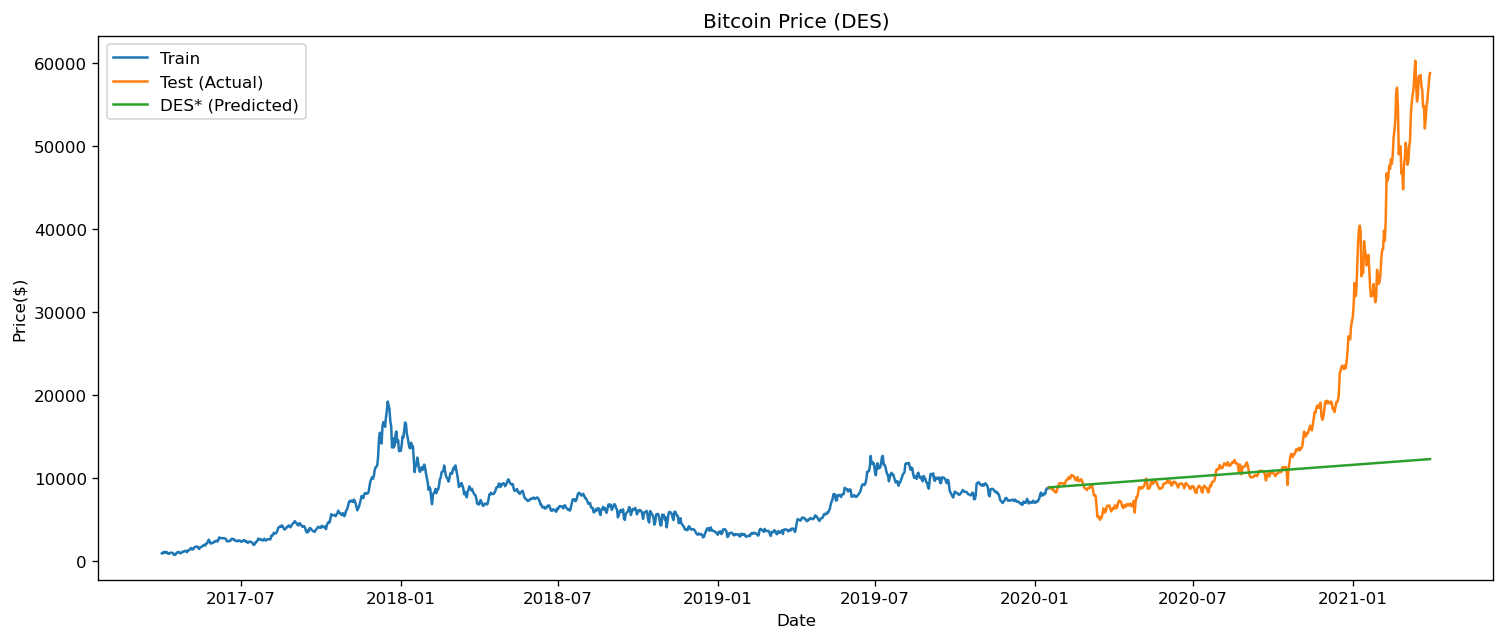

In [ ]:
# plot forecast vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(df2.Weighted_Price[:1022], label='Train')
plt.plot(df2.Weighted_Price[1021:], label='Test (Actual)')
plt.plot(df2.DES[1021:], label='DES* (Predicted)')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.title('Bitcoin Price (DES)')
plt.legend(loc='best')
plt.show()

#### Findings
According to the plot, the forecasting line is responsive to the trend of the test set. By applying double esponential smoothing method, we can capture the direction of the trend. However, as shown in the plot, the prediction applying double exponential smoothing can't present daily fluctuations. We will develop more models to improve the prediction.

## 5.2 Model 2. ARIMA Model
Secondly, I will apply ARIMA model, which stands for AutoRegressive Integrated Moving Average. ARIMA is a commonly used algorithm for analyzing and forecasting time series data, the idea for applying ARIMA is that the past values of the time series can be used to predict its own future values. An ARIMA model has 3 terms (p,d,q), which indicates the specific ARIMA model being used. The three terms (p,d,q) indicates:
* p: number of autoregressive terms (AR order)
* d: number of nonseasonal differences (differencing order)
* q: number of moving-average terms (MA order)

In [ ]:
# retrieve Weighted_Price as series
s_price = df2['Weighted_Price']
price = s_price.values

# split data to training/test data as 70/30
train_size = int(len(s_price) * 0.7)
train, test = price[0:train_size], price[train_size:len(price)]
history = [x for x in train]
prediction = list()

In [ ]:
print(len(train))
print(len(test))

1022
439


### 5.2.1 Find the order of differencing (d)

In [ ]:
# ADF test 
ad_result = adfuller(s_price)
print('ADF Statistic: %f' % ad_result[0])
print('p-value: %f' % ad_result[1])

ADF Statistic: 4.549084
p-value: 1.000000


Since p-value is greater than the significance level (0.05), we fail to reject the null hypothesis and infer that the time series is non-stationary. Thus, differencing is required for the time series.

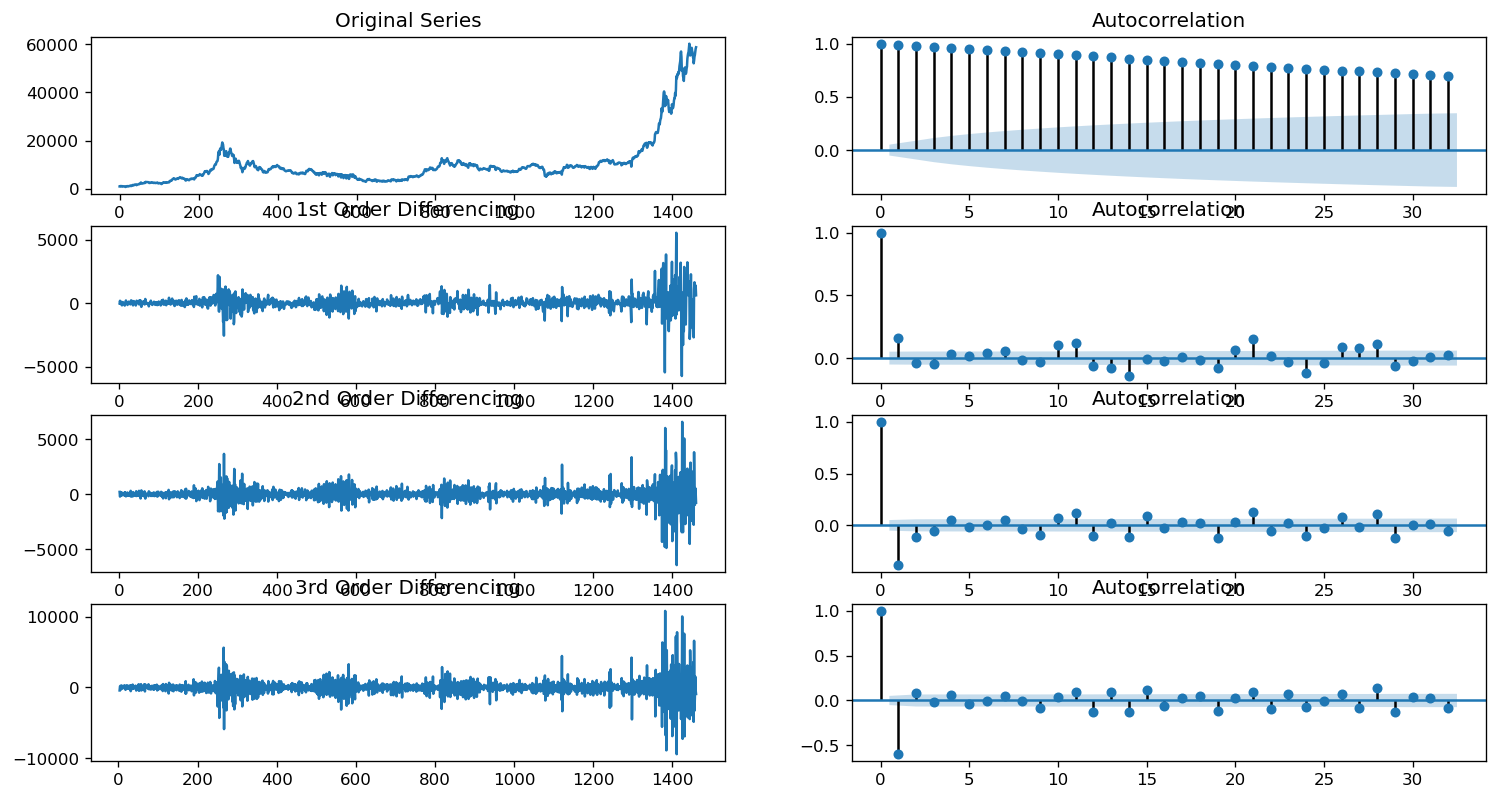

In [ ]:
# convert array to series
s_price2 = pd.Series(price)

# plot for finding the order of differencing (d)
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})
fig, axes = plt.subplots(4, 2)

# original series
axes[0, 0].plot(s_price2)
axes[0, 0].set_title('Original Series')
plot_acf(s_price2, ax=axes[0, 1])

# 1st differencing (d=1)
axes[1, 0].plot(s_price2.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(s_price2.diff().dropna(), ax=axes[1, 1])

# 2nd differencing (d=2)
axes[2, 0].plot(s_price2.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(s_price2.diff().diff().dropna(), ax=axes[2, 1])

# 3rd differencing (d=3)
axes[3, 0].plot(s_price2.diff().diff().diff())
axes[3, 0].set_title('3rd Order Differencing')
plot_acf(s_price2.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

According to the above series, the time series reaches stationarity with two orders of differencing.  Thus, I will set d=2 for the ARIMA model.

### 5.2.2 Find the order of the AR term (p)

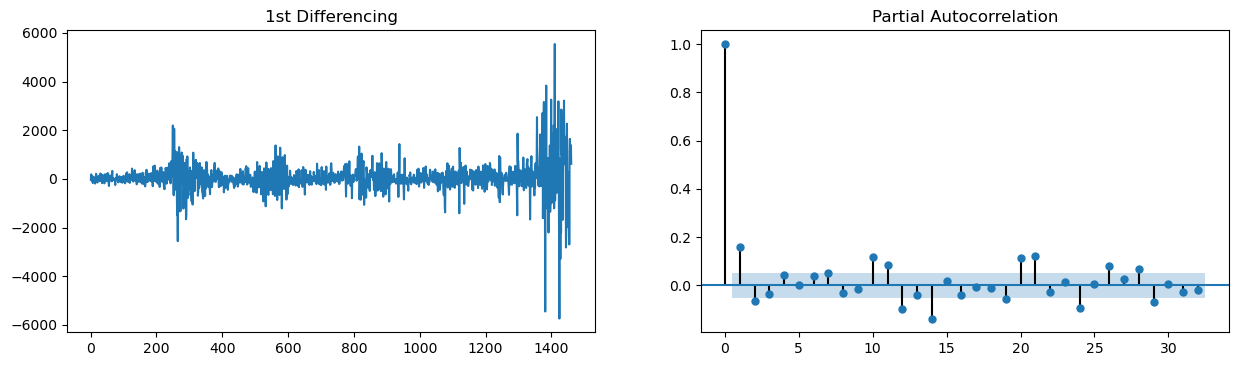

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)

axes[0].plot(s_price2.diff())
axes[0].set_title('1st Differencing')
plot_pacf(s_price2.diff().dropna(), ax=axes[1])

plt.show()

According to the PACF (plot on left-hand side), we can find lag=1 is well above the significance limit (blue area); Lag=2 turns out to touch the significance limit. Thus, I will set p=1 for the ARIMA model.

### 5.2.3 Find the order of the MA term (q)

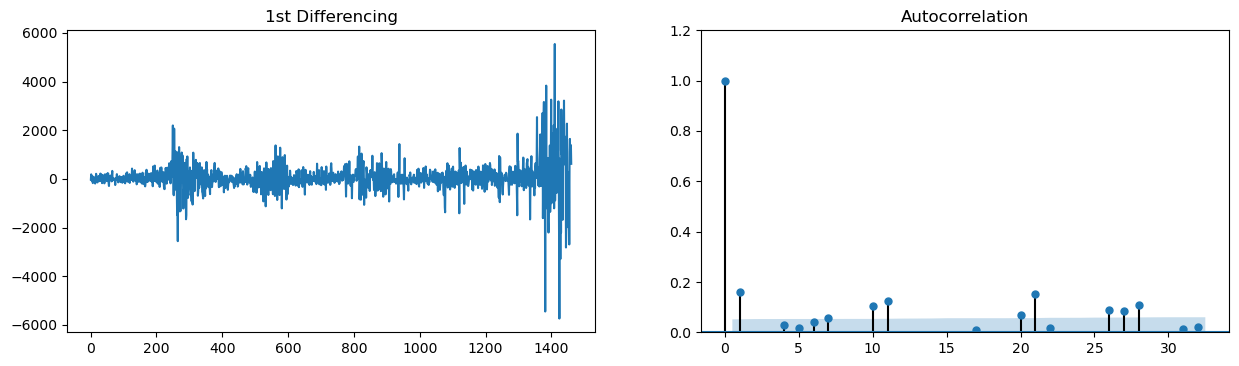

In [ ]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)

axes[0].plot(s_price2.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 1.2))
plot_acf(s_price2.diff().dropna(), ax=axes[1])

plt.show()

As shown in the acf plot, several lags are well above the significance line. In this case, I will tentatively select q as 7. 

In [ ]:
# (p,d,q) = (1,2,7)
model = ARIMA(s_price2, order=(1,2,7))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1459
Model:                 ARIMA(1, 2, 7)   Log Likelihood              -11352.484
Method:                       css-mle   S.D. of innovations            578.650
Date:                Fri, 20 Aug 2021   AIC                          22724.968
Time:                        08:34:50   BIC                          22777.823
Sample:                             2   HQIC                         22744.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1737      0.158      1.098      0.272      -0.136       0.484
ar.L1.D2.y    -0.9192      0.050    -18.434      0.000      -1.017      -0.821
ma.L1.D2.y     0.0847      0.056      1.509      0.1

The summary suggests that the p-value of the AR1 term is smaller than 0.05, which is highly significant. On the other hand, only a part of p-values of the MA terms are significant.

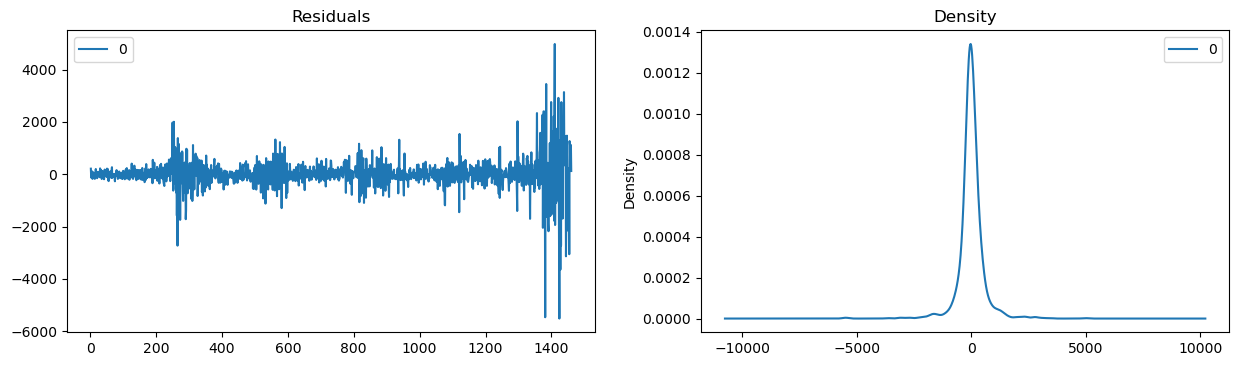

In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors have mean of zero and uniform variance, now we can ensure there are no patterns in time series.

### 5.2.4 Build model and predict

In [ ]:
# build model
# forecast with ARIMA using 1,2,7 as (p,d,q)
model = ARIMA(s_price2, order=(1, 2, 7))

# fit the model
model_fit = model.fit()

# predict
index_start = len(s_price2)
index_end = index_start + 438  # Note: 439 = index438
forecast = model_fit.predict(start=index_start, end=index_end)

In [ ]:
# inverse differenced data
def inverse_difference(history, pred, interval=1):
    return pred + history[-interval]

# store predicted results 
history = [x for x in train]
prediction = list()
day = 1

for pred in forecast:
    inverted = inverse_difference(history, pred, 365) # 365 days
#     print('Day', day, 'price:', round(inverted, 2))
    history.append(round(inverted, 2))
    prediction.append(round(inverted, 2))
    day += 1

In [ ]:
# Test RMSE
rmse_arima = np.sqrt(mean_squared_error(test, prediction))
print('Test RMSE:', round(rmse_arima, 2))

Test RMSE: 19754.79


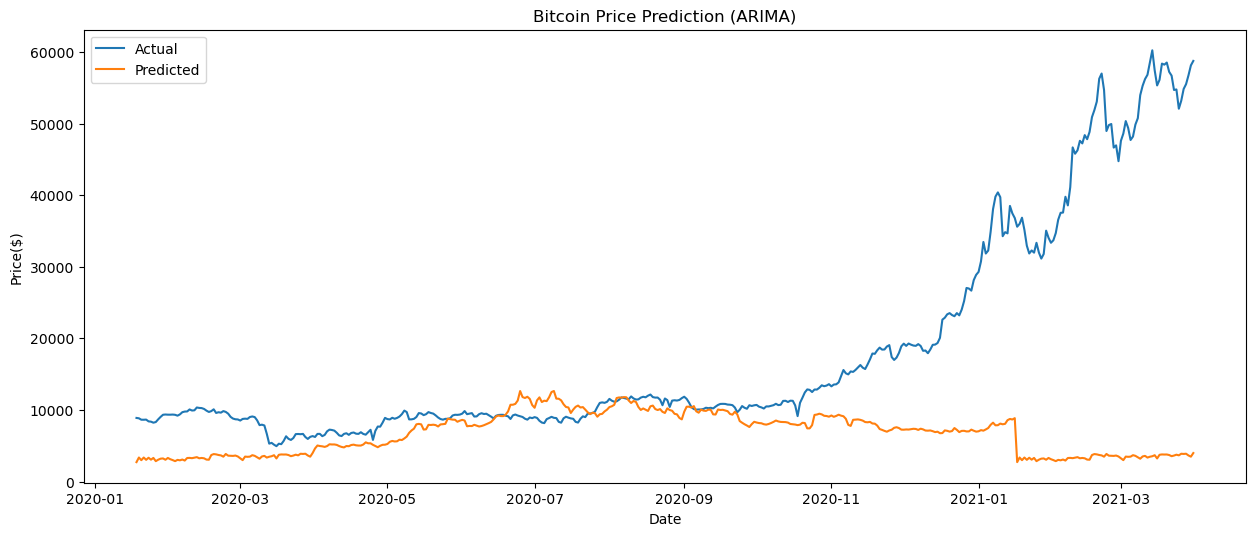

In [ ]:
# plot forecasts v.s. actuals
xticks = s_price.index[train_size:len(price)]

plt.figure(figsize=(15,6))
plt.plot(xticks, test, label='Actual')
plt.plot(xticks, prediction, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.title('Bitcoin Price Prediction (ARIMA)')
plt.legend(loc='best')
plt.show()

#### Findings
According to the plot, from January to October 2020, the forecasting line is closed to the actual trend, and we can found some spikes occurred in both two lines. However, since November 2020, we can see that two lines have significant distance in the plot and the foecasting line performs worse in predicting the trend. Overall, the line barely captures the actual values. The final test RMSE of this ARIMA model is 19754.79.

## 5.3 Model 3. XGBOOST
As one of the most popular machine learning algorithms, XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. Let's apply XGBoost to time series data and see how well does XGBoost perform on Bitcoin price predction. Because of the nature of time series, we have to create time series features from the datetime index.

In [ ]:
# create time series features from datetime index
def create_features(df, label=None):
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    df['Day_of_week'] = df['Date'].dt.dayofweek
    df['Day_of_month'] = df['Date'].dt.day
    df['Day_of_year'] = df['Date'].dt.dayofyear
    df['Week_of_year'] = df['Date'].dt.weekofyear
    X = df[['Hour', 'Month', 'Quarter', 'Year', 'Day_of_week',
            'Day_of_month', 'Day_of_year', 'Week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
# split data to training/test data as 70/30 (similar to the above splitting process)
df3 = df2.copy()
train_size = int(len(df3) * 0.7)
train, test = df3[0:train_size], df3[train_size:len(df3)]

# assign train and test data, features and labels (price)
X_train, y_train = create_features(train, label='Weighted_Price')
X_test, y_test = create_features(test, label='Weighted_Price')

In [ ]:
# use grid search to find the optimal combination of parameters
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [0.05, .1],
              'max_depth': [4, 5, 6],
              'min_child_weight': [5, 10, 15],
              'colsample_bytree': [0.3, 0.5],
              'n_estimators': [100, 500, 1000]}

xgb_grid = GridSearchCV(model, parameters, cv=2, n_jobs=5, verbose=False)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

[08:42:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
-1.5150341281101958
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'objective': 'reg:linear'}


In [ ]:
# set parameters based on the result of grid search
# build model
model = xgb.XGBRegressor(colsample_bytree = 0.5,
                         learning_rate = 0.05,
                         max_depth = 5,
                         min_child_weight=15,
                         n_estimators = 100,
                         objective ='reg:linear')

# fit the model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
          early_stopping_rounds=50, verbose=False)

[08:44:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=15, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

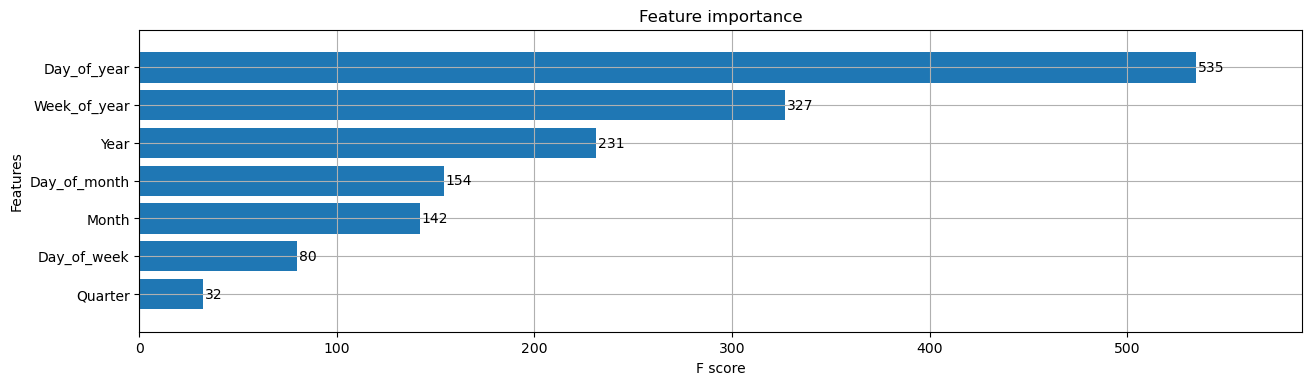

In [ ]:
# plot feature importance
_ = plot_importance(model, height=0.8)

From feature impotance, we can learn that which features the model relies the most to make the prediction. We see that the `Day_of_year` is the most commonly used to split trees, and followed by `Week_of_year` and `Year`.

In [ ]:
# predict
prediction = model.predict(X_test)

# assign predictions to test data
test['Weighted_Price_Pred'] = prediction

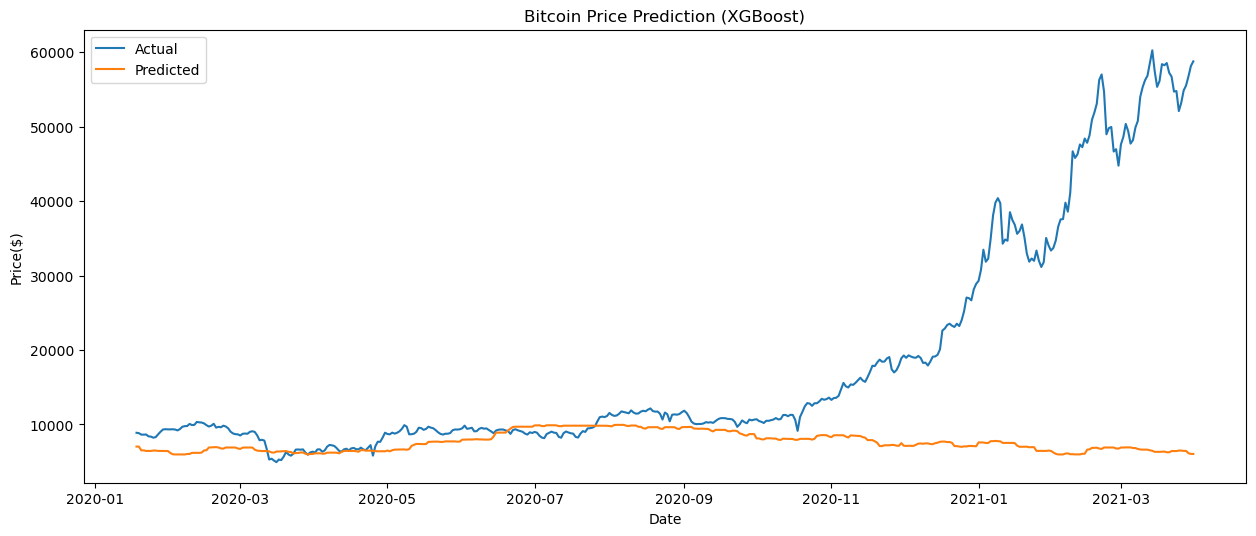

In [ ]:
# plot actuals v.s. forecasts
plt.figure(figsize=(15, 6))
plt.plot(xticks, test['Weighted_Price'], label = 'Actual')
plt.plot(xticks, test['Weighted_Price_Pred'], label = 'Predicted')
plt.title('Bitcoin Price Prediction (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.legend(loc='best')
plt.show()

In [ ]:
rmse_xgboost = np.sqrt(mean_squared_error(test['Weighted_Price'], test['Weighted_Price_Pred']))
print('Test RMSE:', round(rmse_xgboost, 2))

Test RMSE: 18526.6


#### Findings
Similar to the predicted results using ARIMA, but the forecasting is smoother than the previous one. from January to October 2020, the forecasting line is closed to the actual trend, but we can barely find a similar momentum between the two trends. Moreover, since November 2020, we can see that the two lines have apparently different trends in the plot. Similarly, the line barely captures the actual values. The final test RMSE of the XGBoost model is 18526.60.

## 5.4 Model 4. Long Short-Term Memory (LSTM) networks
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network, which are capable of learning long-term dependencies and solving sequence prediction problems. However, in this case, the volatility of Bitcoin dataset become a challenge for LTSM. Below I will demonstrate the process of building  a LSTM network for looking for the lowest RMSE of predicted results.

In [ ]:
# split data to training/test data as 70/30 (repeat above splitting process)
s_price = df2['Weighted_Price']
train_size = int(len(s_price) * 0.7)
train, test = s_price[0:train_size], s_price[train_size:len(s_price)]

train_values = train.values
train_values = np.reshape(train_values, (len(train_values), 1))

# scale the data
scaler = MinMaxScaler()
train_values = scaler.fit_transform(train_values)

# assign training values
X_train = train_values[0: len(train_values)-1]
X_train = np.reshape(X_train, (len(X_train), 1, 1))
y_train = train_values[1: len(train_values)]

In [ ]:
# create model
model = Sequential()
model.add(LSTM(10, input_shape = (None,1), activation='relu', return_sequences=True))
model.add(Dense(1))

# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the model
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [ ]:
# assign test and predicted values
test_values = test.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))

# predict
predict = model.predict(test_values)

# reshape
predict = np.reshape(predict, (len(predict), 1))

# convert to original values from scaled values
predict = scaler.inverse_transform(predict)

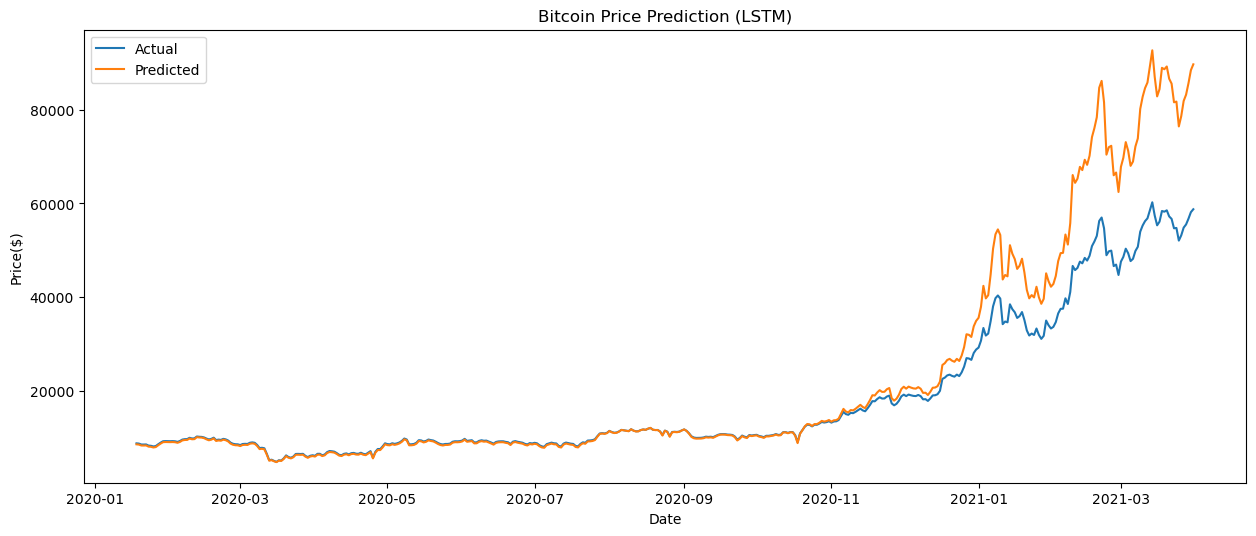

In [ ]:
# plot actuals v.s. forecasts
plt.figure(figsize=(15, 6))
xticks = s_price.index[train_size:len(price)]
plt.plot(xticks, test.values, label = 'Actual')
plt.plot(xticks, predict, label = 'Predicted')
plt.title('Bitcoin Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Test RMSE
test = test.reset_index()
rmse_lstm = np.sqrt(mean_squared_error(test['Weighted_Price'].values, predict))
print('Test RMSE: ', round(rmse_lstm, 2))

Test RMSE:  9178.1


#### Findings
After several tests and combinations of parameters, the model with epochs=50 and batch_size=32 generates comparatively lower RMSE. According to the plot, LSTM generates a forecasting line capturing most of the momentum and the lowest RMSE of 9178.1. However, we should consider overfitting issue in this case.

# 6. Conclusions

In [ ]:
data = {'Model': ['DES', 'ARIMA', 'XGBoost', 'LSTM'], 
        'Test RMSE': [round(rmse_des, 2), round(rmse_arima, 2), round(rmse_xgboost, 2), round(rmse_lstm, 2)]}
df_rmse = pd.DataFrame(data)
df_rmse

Model  Test RMSE
0      DES   15937.08
1    ARIMA   19754.79
2  XGBoost   18526.60
3     LSTM    9178.10

The final results of all the models are listed in the above table. Unlike usual time series data we use for prediction, Bitcoin price is extremely volatile and unpredictable. Unsurprisingly, it is challenging for the models to provide an accurate prediction. We have the conclusions as follows:
* Though the long short-term memory networks are not ideal for forecasting turbulent markets like Bitcoin, compared with the other three models, the LSTM has the lowest test RMSE and the most effective performance in Bitcoin price prediction.
* The double exponential smoothing method has the second-lowest RMSE, however, the predicted result can only indicate an upward trend in the time interval of test data. In other words, it may not be able to capture the movement of each day, but it may provide a reliable result of suggesting a downward or an upward trend of price fluctuation.
* ARIMA and XGBoost models provide similar test RMSEs. Compared to the other models, these two models prove to be less effective when handling volatile data like Bitcoin prices.

To sum up, LSTM networks seem to provide the lowest RMSE, but it doesn't necessarily indicate the best prediction. We still have to consider the overfitting issue when we apply the model. Given the volatility of data, we may have difficulty generating accurate predictions. Furthermore, besides grid search and manually adjusting parameters, there must still be more combinations or optimized methods to improve the model. Overall, it is important to note that the LSTM can predict more accurately among the four machine learning algorithms. Nevertheless, considering the nature of the unpredictability of the crypto market, we should always be careful when we are in an attempt to predict any volatile data.

### References
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
* https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv